# **Notebook zur Evaluation - Trajektorien**
***

In [1064]:
import csv
import numpy as np
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.cm as cm
import plotly.graph_objects as go

***
### **Trajektorien CSVs laden**

In [1065]:
hook_num = 8
v = 10
hook_model = 'A'
# frame = '_work'
frame = ''
num_interp_points = 101

hole_width = 8
hole_height = 12

hook_width = 1.8
hook_height = 5.4

In [1066]:
def load_csv_to_trajectory(filepath):
    """Lädt die CSV und stellt Trajektorie-Liste wieder her"""
    trajectory = []
    with open(filepath, mode='r', newline='') as file:
        reader = csv.reader(file)
        next(reader)  # Überspringe Kopfzeile

        for row in reader:
            numbers = list(map(float, row))
            trans = numbers[:3]
            rot = numbers[3:]
            trajectory.append((trans, rot))
    return trajectory

In [1067]:
traj_optim_path = '/home/mo/Thesis/Evaluation/Trajektorientests/Modell' + hook_model + '/v_' + str(v) + '/' + str(hook_num) + '/trajectory_0' + str(frame) + '.csv'
traj_1_path = '/home/mo/Thesis/Evaluation/Trajektorientests/Modell' + hook_model + '/v_' + str(v) + '/' + str(hook_num) + '/trajectory_1' + str(frame) + '.csv'
traj_2_path = '/home/mo/Thesis/Evaluation/Trajektorientests/Modell' + hook_model + '/v_' + str(v) + '/' + str(hook_num) + '/trajectory_2' + str(frame) + '.csv'
traj_3_path = '/home/mo/Thesis/Evaluation/Trajektorientests/Modell' + hook_model + '/v_' + str(v) + '/' + str(hook_num) + '/trajectory_3' + str(frame) + '.csv'
traj_4_path = '/home/mo/Thesis/Evaluation/Trajektorientests/Modell' + hook_model + '/v_' + str(v) + '/' + str(hook_num) + '/trajectory_4' + str(frame) + '.csv'

In [1068]:
trajectory_optim = load_csv_to_trajectory(traj_optim_path)
trajectory_1 = load_csv_to_trajectory(traj_1_path)
trajectory_2 = load_csv_to_trajectory(traj_2_path)
trajectory_3 = load_csv_to_trajectory(traj_3_path)
trajectory_4 = load_csv_to_trajectory(traj_4_path)

In [1069]:
print(trajectory_1)
print(trajectory_3)

[([-237.49946134925557, 921.0842143424538, 737.0250560808047], [-49.36774947601173, 27.260877631982492, -6.471474335289431]), ([-245.0652927273598, 927.0117644737675, 734.3227377769451], [-40.88625978419696, 33.83604928436737, -54.97932662723165]), ([-245.49082769173998, 929.3949601204638, 733.6864369652078], [-60.066507025332044, 23.012164199936805, 27.890645249226477]), ([-246.44285527192085, 929.5140902161473, 733.2940502244157], [-47.40960392297518, 29.540420161552102, -30.52005441442944]), ([-247.2195263319531, 930.7807007817815, 732.814870255652], [-66.13010083632847, 22.22283268757209, 26.25382514953169]), ([-248.17804245028884, 930.8686105298398, 732.2568102165819], [-42.82930376487494, 30.984955001187448, -28.71808142903839]), ([-248.9639415386702, 932.1419412397222, 731.9347100806788], [-63.47228260057858, 22.591730052455862, 28.15548651242797]), ([-249.92606325194083, 932.2297061845728, 731.4556822366035], [-50.16461901808247, 22.417380908782345, 34.87274189061171]), ([-250.

***
### **Interpolation der Trajektorie**

In [1070]:
def interpolate_trajectory(traj, num_points):
    """
    Interpoliert eine Trajektorie auf `num_points` gleichmäßig verteilte Punkte.
    Nur die translatorischen Komponenten werden verwendet (3D Punkte).
    """
    positions = np.array([p[0] for p in traj])  # Nur Positionen
    rotations = np.array([p[1] for p in traj])  # Nur Rotationen

    # Abstände zwischen aufeinanderfolgenden Punkten
    deltas_trans = np.linalg.norm(np.diff(positions, axis=0), axis=1)
    cumulative_dist_trans = np.concatenate([[0], np.cumsum(deltas_trans)])
    target_distances_trans = np.linspace(0, cumulative_dist_trans[-1], num_points)

    interp_positions = []
    for dist in target_distances_trans:
        idx = np.searchsorted(cumulative_dist_trans, dist) - 1
        idx = np.clip(idx, 0, len(positions) - 2)
        t = (dist - cumulative_dist_trans[idx]) / (cumulative_dist_trans[idx + 1] - cumulative_dist_trans[idx])
        point = (1 - t) * positions[idx] + t * positions[idx + 1]
        interp_positions.append(point)

    # Rotationsteil
    if np.allclose(rotations, rotations[0]):  # wenn alle Rotationswerte gleich sind (Ansatz 2-4)
        interp_rotations = [rotations[0]] * num_points
    else:
        deltas_rot = np.linalg.norm(np.diff(rotations, axis=0), axis=1)
        cumulative_dist_rot = np.concatenate([[0], np.cumsum(deltas_rot)])
        target_distances_rot = np.linspace(0, cumulative_dist_rot[-1], num_points)

        interp_rotations = []
        for rot in target_distances_rot:
            idx = np.searchsorted(cumulative_dist_rot, rot) - 1
            idx = np.clip(idx, 0, len(rotations) - 2)
            denom = cumulative_dist_rot[idx + 1] - cumulative_dist_rot[idx]
            t = 0 if denom == 0 else (rot - cumulative_dist_rot[idx]) / denom
            point = (1 - t) * rotations[idx] + t * rotations[idx + 1]
            interp_rotations.append(point)
    return np.array(interp_positions), np.array(interp_rotations)


def fix_rpy(rpy):
    roll, pitch, yaw = rpy
    return [roll, -pitch, yaw]


def compute_rectangle_corners(trajectory, frame='', width=8, height=12):
    rectangles = []

    half_w = width / 2
    half_h = height / 2

    # Rechteck immer in der XZ-Ebene
    local_corners = np.array([
        [-half_w, 0, -half_h],
        [ half_w, 0, -half_h],
        [ half_w, 0,  half_h],
        [-half_w, 0,  half_h]
    ])

    for pos, rpy in trajectory:
        if frame == '_work':
            rpy = fix_rpy(rpy)

        rot = R.from_euler('xyz', rpy, degrees=True)
        rotated_corners = rot.apply(local_corners)
        translated_corners = rotated_corners + np.array(pos)
        rectangles.append(translated_corners.tolist())

    return rectangles

In [1071]:
interp_positions_optim, interp_rotations_optim = interpolate_trajectory(trajectory_optim, num_interp_points)
trajectory_optim = list(zip(interp_positions_optim, interp_rotations_optim))
rectangles_optim = compute_rectangle_corners(trajectory_optim, frame=frame, width=hole_width, height=hole_height)
rectangles_optim_hooks = compute_rectangle_corners(trajectory_optim, frame=frame, width = hook_width, height = hook_height)

interp_positions_1, interp_rotations_1 = interpolate_trajectory(trajectory_1, num_interp_points)
trajectory_1 = list(zip(interp_positions_1, interp_rotations_1))
rectangles_1 = compute_rectangle_corners(trajectory_1, frame=frame, width=hole_width, height=hole_height)

interp_positions_2, interp_rotations_2 = interpolate_trajectory(trajectory_2, num_interp_points)
trajectory_2 = list(zip(interp_positions_2, interp_rotations_2))
rectangles_2 = compute_rectangle_corners(trajectory_2, frame=frame, width=hole_width, height=hole_height)

interp_positions_3, interp_rotations_3 = interpolate_trajectory(trajectory_3, num_interp_points)
trajectory_3 = list(zip(interp_positions_3, interp_rotations_3))
rectangles_3 = compute_rectangle_corners(trajectory_3, frame=frame, width=hole_width, height=hole_height)

interp_positions_4, interp_rotations_4 = interpolate_trajectory(trajectory_4, num_interp_points)
trajectory_4 = list(zip(interp_positions_4, interp_rotations_4))
rectangles_4 = compute_rectangle_corners(trajectory_4, frame=frame, width=hole_width, height=hole_height)

***
### **Berechnung der Abweichungen zwischen Trajektorie und Optimalwerten**

In [1072]:
def absolute_traj_differences(traj1, traj2, frame='_work'):
    measurements = {}
    # Globale Diffs
    x_diffs, y_diffs, z_diffs = [], [], []
    roll_diffs, pitch_diffs, yaw_diffs = [], [], []
    euclidean_diffs = []

    # Lokale Diffs
    x_diffs_local, y_diffs_local, z_diffs_local = [], [], []

    if len(traj1) != len(traj2):
        print("ERROR - Length of trajectories unequal!")
    else:
        for idx in range(len(traj1)):
            pos1, rpy1 = traj1[idx]
            pos2, rpy2 = traj2[idx]

            pos1 = np.array(pos1)
            pos2 = np.array(pos2)
            rot1 = np.array(rpy1)
            rot2 = np.array(rpy2)

            pos_diff = pos2 - pos1
            rot_diff = rot2 - rot1

            # globale Differenzen
            euclidean_diffs.append(np.linalg.norm(pos_diff))
            x_diffs.append(pos_diff[0])
            y_diffs.append(pos_diff[1])
            z_diffs.append(pos_diff[2])
            roll_diffs.append(rot_diff[0])
            pitch_diffs.append(rot_diff[1])
            yaw_diffs.append(rot_diff[2])

            # lokale Transformierung
            if frame == '_work':
                r = R.from_euler('xyz', fix_rpy(rpy1), degrees=True)
            else:
                r = R.from_euler('xyz', rpy1, degrees=True)

            local_diff = r.inv().apply(pos_diff)
            x_diffs_local.append(local_diff[0])
            y_diffs_local.append(local_diff[1])
            z_diffs_local.append(local_diff[2])

    # globale Einträge
    measurements['x_diffs'] = x_diffs
    measurements['y_diffs'] = y_diffs
    measurements['z_diffs'] = z_diffs
    measurements['roll_diffs'] = roll_diffs
    measurements['pitch_diffs'] = pitch_diffs
    measurements['yaw_diffs'] = yaw_diffs
    measurements['euclidean_diffs'] = euclidean_diffs

    measurements['x_min'] = np.min(x_diffs)
    measurements['x_max'] = np.max(x_diffs)
    measurements['y_min'] = np.min(y_diffs)
    measurements['y_max'] = np.max(y_diffs)
    measurements['z_min'] = np.min(z_diffs)
    measurements['z_max'] = np.max(z_diffs)

    measurements['x_diffs_mean'] = np.mean(x_diffs)
    measurements['y_diffs_mean'] = np.mean(y_diffs)
    measurements['z_diffs_mean'] = np.mean(z_diffs)

    # lokale Einträge
    measurements['x_diffs_local'] = x_diffs_local
    measurements['y_diffs_local'] = y_diffs_local
    measurements['z_diffs_local'] = z_diffs_local

    measurements['x_min_local'] = np.min(x_diffs_local)
    measurements['x_max_local'] = np.max(x_diffs_local)
    measurements['y_min_local'] = np.min(y_diffs_local)
    measurements['y_max_local'] = np.max(y_diffs_local)
    measurements['z_min_local'] = np.min(z_diffs_local)
    measurements['z_max_local'] = np.max(z_diffs_local)

    measurements['x_diffs_mean_local'] = np.mean(x_diffs_local)
    measurements['y_diffs_mean_local'] = np.mean(y_diffs_local)
    measurements['z_diffs_mean_local'] = np.mean(z_diffs_local)

    return measurements

In [1073]:
traj1_measurements = absolute_traj_differences(traj1 = trajectory_optim, traj2 = trajectory_1)
traj2_measurements = absolute_traj_differences(traj1 = trajectory_optim, traj2 = trajectory_2)
traj3_measurements = absolute_traj_differences(traj1 = trajectory_optim, traj2 = trajectory_3)
traj4_measurements = absolute_traj_differences(traj1 = trajectory_optim, traj2 = trajectory_4)

In [1074]:
def plot_position_differences(measurements, hook_num, trajectory_process=0):
    # Globale Werte
    x = measurements['x_diffs']
    y = measurements['y_diffs']
    z = measurements['z_diffs']
    x_diffs_mean = measurements['x_diffs_mean']
    y_diffs_mean = measurements['y_diffs_mean']
    z_diffs_mean = measurements['z_diffs_mean']

    # Lokale Werte
    x_loc = measurements['x_diffs_local']
    y_loc = measurements['y_diffs_local']
    z_loc = measurements['z_diffs_local']
    x_loc_mean = measurements['x_diffs_mean_local']
    y_loc_mean = measurements['y_diffs_mean_local']
    z_loc_mean = measurements['z_diffs_mean_local']

    n = len(x)
    t = list(range(n))

    fig, axs = plt.subplots(2, 1, figsize=(14, 10))
    fig.suptitle(f"Positionsdifferenzen für Haken {hook_num} - Trajektorien-Ansatz {trajectory_process}", fontsize=16)

    ##### Subplot 1: Globale Differenzen
    axs[0].plot(t, x, label='x-Differenz', color='red')
    axs[0].axhline(x_diffs_mean, linestyle='--', color='red', label=rf"$\bar{{x}}$ = {x_diffs_mean:.3f}")
    axs[0].text(n * 0.2, x_diffs_mean + 0.05, rf"$\bar{{x}}$ = {x_diffs_mean:.3f}", color='red',
                fontsize=10, bbox=dict(facecolor='white', edgecolor='red', alpha=0.9))

    axs[0].plot(t, y, label='y-Differenz', color='green')
    axs[0].axhline(y_diffs_mean, linestyle='--', color='green', label=rf"$\bar{{y}}$ = {y_diffs_mean:.3f}")
    axs[0].text(n * 0.3, y_diffs_mean + 0.05, rf"$\bar{{y}}$ = {y_diffs_mean:.3f}", color='green',
                fontsize=10, bbox=dict(facecolor='white', edgecolor='green', alpha=0.9))

    axs[0].plot(t, z, label='z-Differenz', color='blue')
    axs[0].axhline(z_diffs_mean, linestyle='--', color='blue', label=rf"$\bar{{z}}$ = {z_diffs_mean:.3f}")
    axs[0].text(n * 0.4, z_diffs_mean + 0.05, rf"$\bar{{z}}$ = {z_diffs_mean:.3f}", color='blue',
                fontsize=10, bbox=dict(facecolor='white', edgecolor='blue', alpha=0.9))

    axs[0].set_title("Globale Positionsabweichung")
    axs[0].set_xlabel('Trajektorienpunkt')
    axs[0].set_ylabel('Differenz [mm]')
    axs[0].set_xlim(0, len(x))
    axs[0].legend()
    axs[0].grid(True)


    ##### Subplot 2: Lokale Differenzen
    axs[1].plot(t, x_loc, label='x-Differenz (lokal)', color='red')
    axs[1].axhline(x_loc_mean, linestyle=':', color='red', label=rf"$\bar{{x}}$ = {x_loc_mean:.3f}")
    axs[1].text(n * 0.2, x_loc_mean + 0.05, rf"$\bar{{x}}$ = {x_loc_mean:.3f}", color='red',
                fontsize=10, bbox=dict(facecolor='white', edgecolor='red', alpha=0.9))

    axs[1].plot(t, y_loc, label='y-Differenz (lokal)', color='green')
    axs[1].axhline(y_loc_mean, linestyle=':', color='green', label=rf"$\bar{{y}}$ = {y_loc_mean:.3f}")
    axs[1].text(n * 0.3, y_loc_mean + 0.05, rf"$\bar{{y}}$ = {y_loc_mean:.3f}", color='green',
                fontsize=10, bbox=dict(facecolor='white', edgecolor='green', alpha=0.9))

    axs[1].plot(t, z_loc, label='z-Differenz (lokal)', color='blue')
    axs[1].axhline(z_loc_mean, linestyle=':', color='blue', label=rf"$\bar{{z}}$ = {z_loc_mean:.3f}")
    axs[1].text(n * 0.4, z_loc_mean + 0.05, rf"$\bar{{z}}$ = {z_loc_mean:.3f}", color='blue',
                fontsize=10, bbox=dict(facecolor='white', edgecolor='blue', alpha=0.9))
    
    delta_width = (hole_width - hook_width) / 2
    delta_height = (hole_height - hole_width) / 2

    axs[1].plot(t, [delta_width] * len(x), linestyle='--', color='red', label='Kollisionsgrenze entlang X')
    axs[1].plot(t, [-delta_width] * len(x), linestyle='--', color='red')
    axs[1].plot(t, [delta_height] * len(x), linestyle='--', color='blue', label='Kollisionsgrenze entlang Z')
    axs[1].plot(t, [-delta_height] * len(x), linestyle='--', color='blue')

    axs[1].set_title("Lokale Positionsabweichung")
    axs[1].set_xlabel('Trajektorienpunkt')
    axs[1].set_ylabel('Differenz [mm]')
    axs[1].set_xlim(0, len(x))
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [1075]:
def show_measurements(dict, hook_num, trajectory_process=0):
    print("-------------------------------------------------------------")
    print(f"Messwerte für Trajektorie - Haken {hook_num} - Trajektorien-Ansatz {trajectory_process}\n")
    print("Absolute Distanzen\n")
    print(f"x max [WORK]: {dict['x_max']:.4f}mm - x max [LOCAL]: {dict['x_max_local']:.4f}mm")
    print(f"x min [WORK]: {dict['x_min']:.4f}mm - x min [LOCAL]: {dict['x_min_local']:.4f}mm")
    print(f"y max [WORK]: {dict['y_max']:.4f}mm - y max [LOCAL]: {dict['y_max_local']:.4f}mm")
    print(f"y min [WORK]: {dict['y_min']:.4f}mm - y min [LOCAL]: {dict['y_min_local']:.4f}mm")
    print(f"z max [WORK]: {dict['z_max']:.4f}mm - z max [LOCAL]: {dict['z_max_local']:.4f}mm")
    print(f"z min [WORK]: {dict['z_min']:.4f}mm - z min [LOCAL]: {dict['z_min_local']:.4f}mm\n")

    print(f"x mean [WORK]: {dict['x_diffs_mean']:.4f}mm - x mean [LOCAL]: {dict['x_diffs_mean_local']:.4f}mm")
    print(f"y mean [WORK]: {dict['y_diffs_mean']:.4f}mm - y mean [LOCAL]: {dict['y_diffs_mean_local']:.4f}mm")
    print(f"z mean [WORK]: {dict['z_diffs_mean']:.4f}mm - z mean [LOCAL]: {dict['z_diffs_mean_local']:.4f}mm\n")

    print()
    print(f"Maximale Euklidsche Distanz [WORK]: {np.max(dict['euclidean_diffs']):.4f}\n")
    
    print()
    print("Roll-Pitch-Yaw Abweichungen\n")
    print(f"Maximale Abweichung Roll (x) [WORK]: {np.max(dict['roll_diffs']):.4f}")
    print(f"Maximale Abweichung Pitch (y) [WORK]: {np.max(dict['pitch_diffs']):.4f}°")
    print(f"Maximale Abweichung Yaw (z) [WORK]: {np.max(dict['yaw_diffs']):.4f}°")

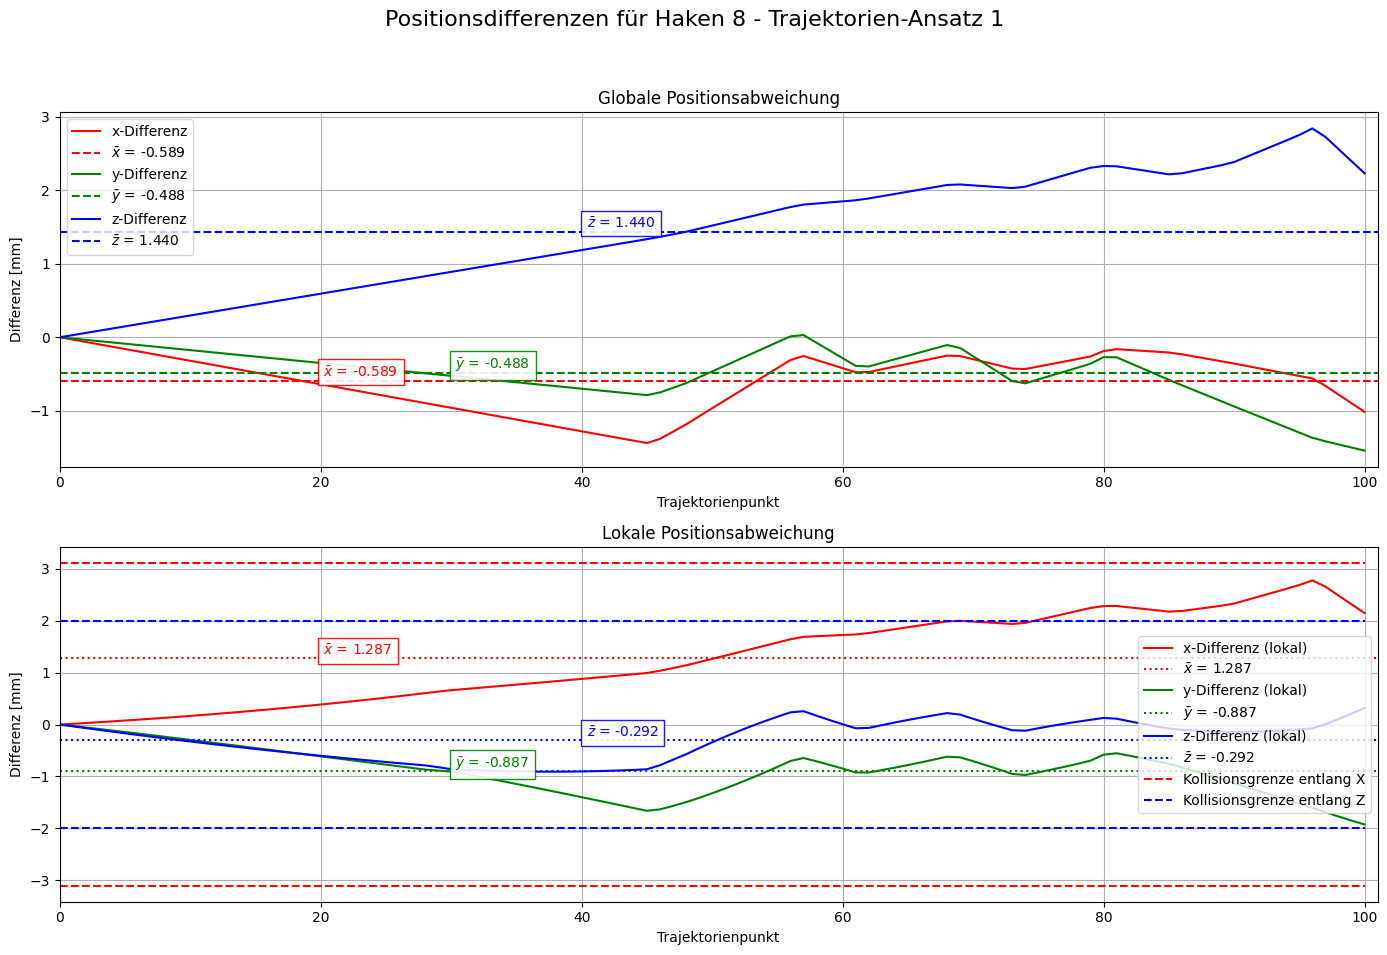

-------------------------------------------------------------
Messwerte für Trajektorie - Haken 8 - Trajektorien-Ansatz 1

Absolute Distanzen

x max [WORK]: 0.0000mm - x max [LOCAL]: 2.7736mm
x min [WORK]: -1.4406mm - x min [LOCAL]: 0.0000mm
y max [WORK]: 0.0304mm - y max [LOCAL]: 0.0000mm
y min [WORK]: -1.5433mm - y min [LOCAL]: -1.9235mm
z max [WORK]: 2.8438mm - z max [LOCAL]: 0.3184mm
z min [WORK]: -0.0000mm - z min [LOCAL]: -0.9071mm

x mean [WORK]: -0.5888mm - x mean [LOCAL]: 1.2874mm
y mean [WORK]: -0.4875mm - y mean [LOCAL]: -0.8868mm
z mean [WORK]: 1.4396mm - z mean [LOCAL]: -0.2916mm


Maximale Euklidsche Distanz [WORK]: 3.2052


Roll-Pitch-Yaw Abweichungen

Maximale Abweichung Roll (x) [WORK]: 216.6946
Maximale Abweichung Pitch (y) [WORK]: -18.1907°
Maximale Abweichung Yaw (z) [WORK]: 64.0278°


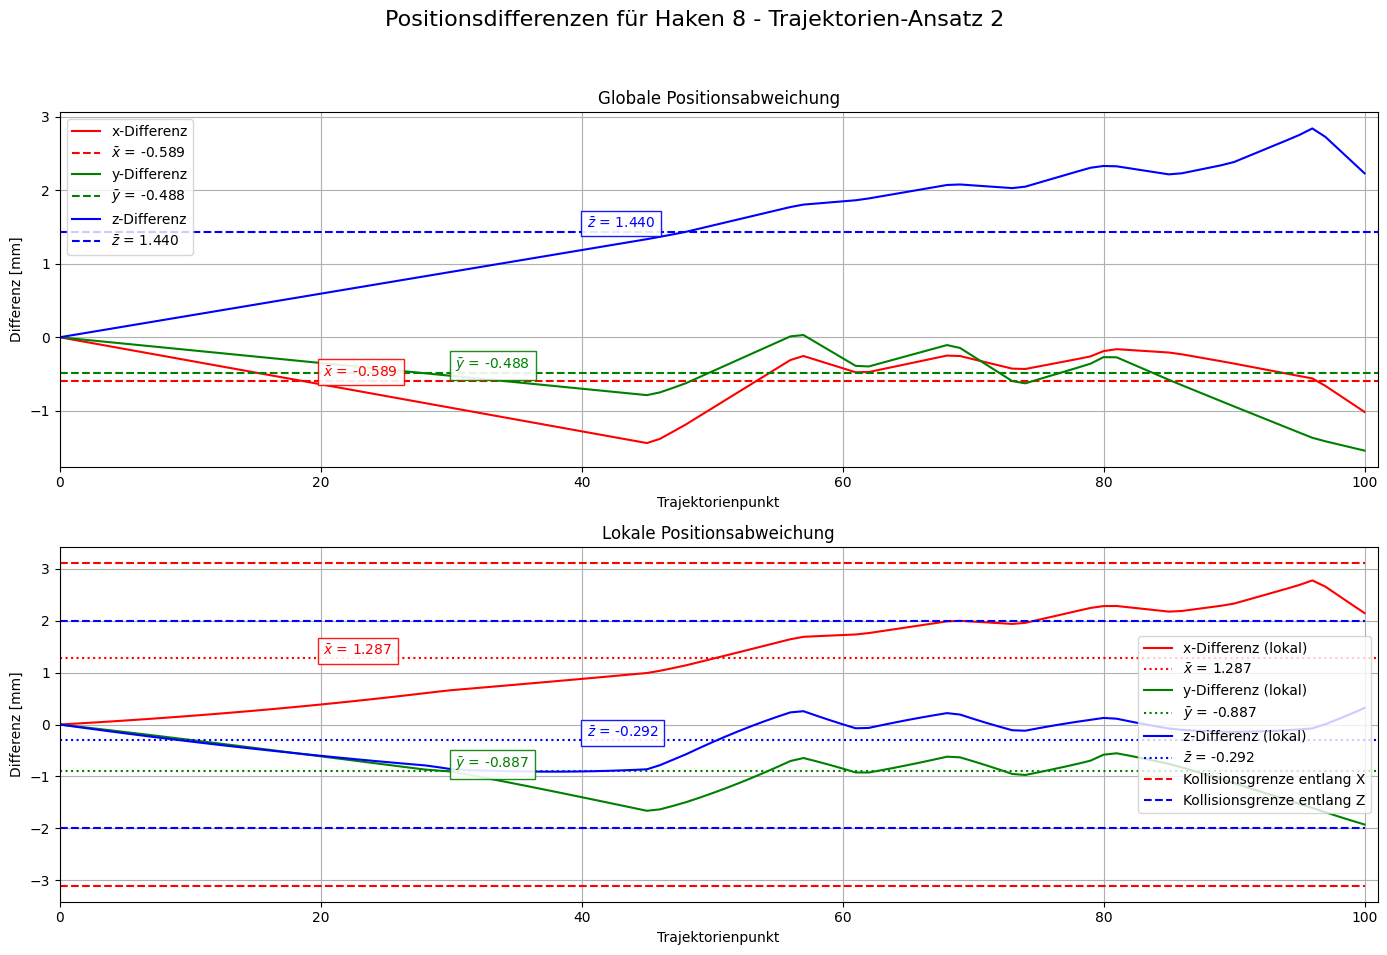

-------------------------------------------------------------
Messwerte für Trajektorie - Haken 8 - Trajektorien-Ansatz 2

Absolute Distanzen

x max [WORK]: 0.0000mm - x max [LOCAL]: 2.7736mm
x min [WORK]: -1.4406mm - x min [LOCAL]: 0.0000mm
y max [WORK]: 0.0304mm - y max [LOCAL]: 0.0000mm
y min [WORK]: -1.5433mm - y min [LOCAL]: -1.9235mm
z max [WORK]: 2.8438mm - z max [LOCAL]: 0.3184mm
z min [WORK]: -0.0000mm - z min [LOCAL]: -0.9071mm

x mean [WORK]: -0.5888mm - x mean [LOCAL]: 1.2874mm
y mean [WORK]: -0.4875mm - y mean [LOCAL]: -0.8868mm
z mean [WORK]: 1.4396mm - z mean [LOCAL]: -0.2916mm


Maximale Euklidsche Distanz [WORK]: 3.2052


Roll-Pitch-Yaw Abweichungen

Maximale Abweichung Roll (x) [WORK]: 40.5324
Maximale Abweichung Pitch (y) [WORK]: -18.5253°
Maximale Abweichung Yaw (z) [WORK]: 38.6338°


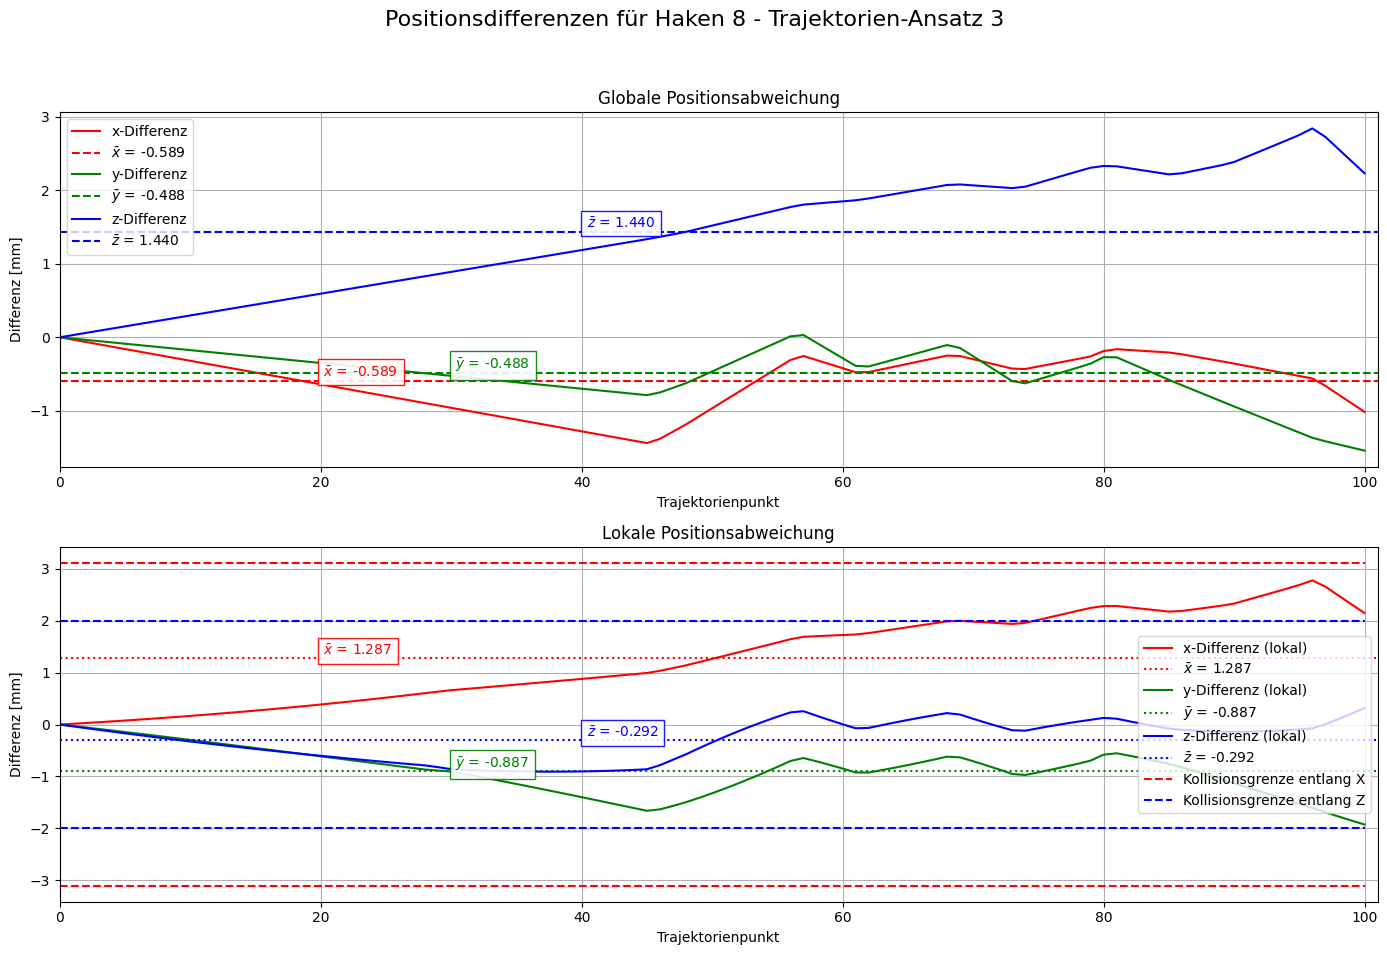

-------------------------------------------------------------
Messwerte für Trajektorie - Haken 8 - Trajektorien-Ansatz 3

Absolute Distanzen

x max [WORK]: 0.0000mm - x max [LOCAL]: 2.7736mm
x min [WORK]: -1.4406mm - x min [LOCAL]: 0.0000mm
y max [WORK]: 0.0304mm - y max [LOCAL]: 0.0000mm
y min [WORK]: -1.5433mm - y min [LOCAL]: -1.9235mm
z max [WORK]: 2.8438mm - z max [LOCAL]: 0.3184mm
z min [WORK]: -0.0000mm - z min [LOCAL]: -0.9071mm

x mean [WORK]: -0.5888mm - x mean [LOCAL]: 1.2874mm
y mean [WORK]: -0.4875mm - y mean [LOCAL]: -0.8868mm
z mean [WORK]: 1.4396mm - z mean [LOCAL]: -0.2916mm


Maximale Euklidsche Distanz [WORK]: 3.2052


Roll-Pitch-Yaw Abweichungen

Maximale Abweichung Roll (x) [WORK]: 20.2662
Maximale Abweichung Pitch (y) [WORK]: -9.2627°
Maximale Abweichung Yaw (z) [WORK]: 19.3169°


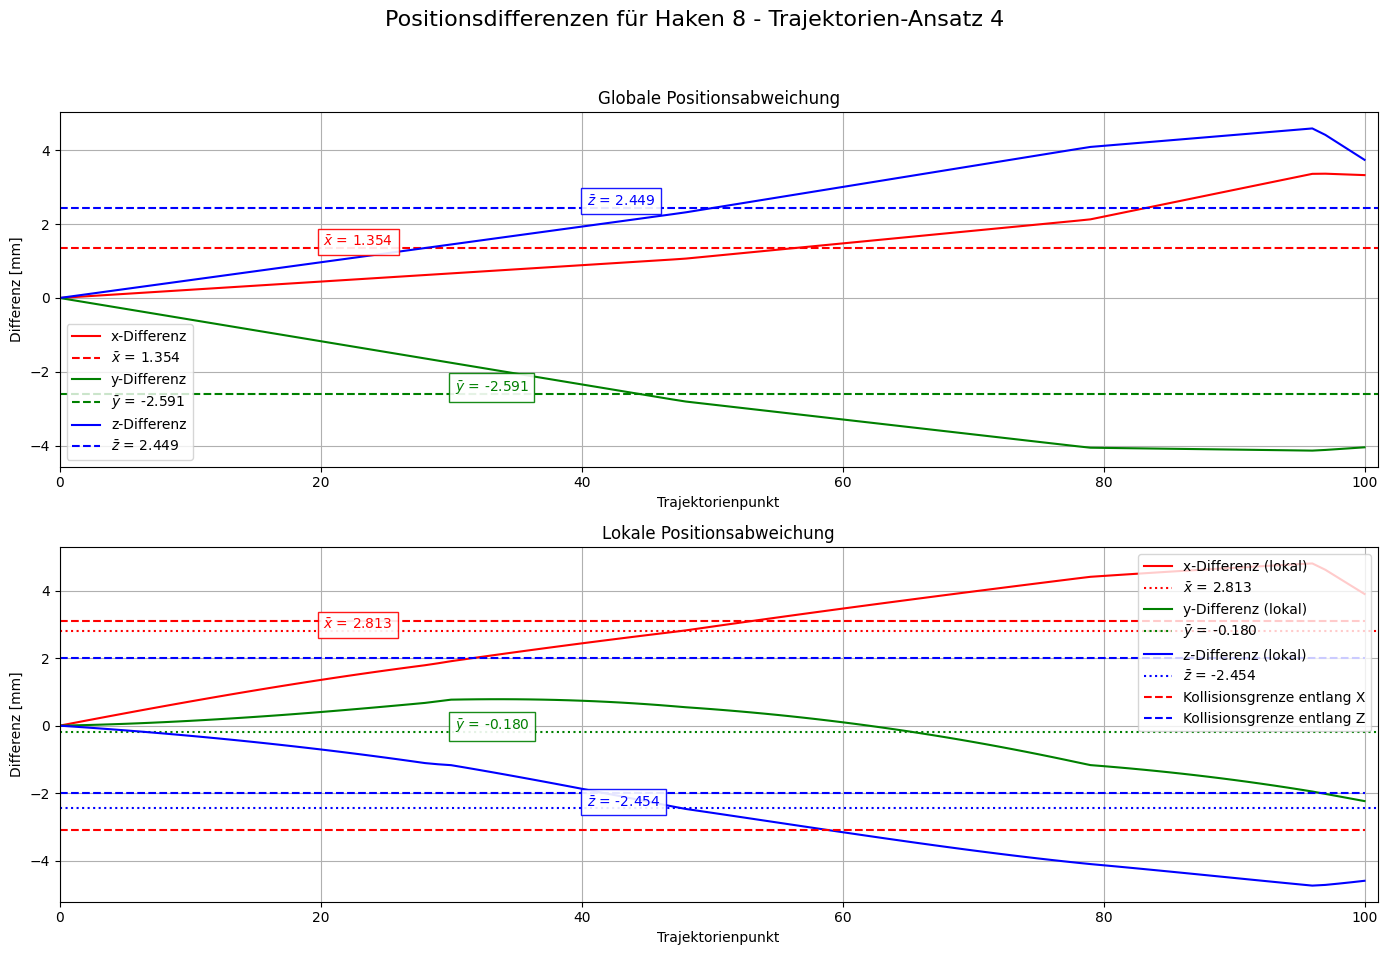

-------------------------------------------------------------
Messwerte für Trajektorie - Haken 8 - Trajektorien-Ansatz 4

Absolute Distanzen

x max [WORK]: 3.3647mm - x max [LOCAL]: 4.8096mm
x min [WORK]: 0.0000mm - x min [LOCAL]: 0.0000mm
y max [WORK]: -0.0000mm - y max [LOCAL]: 0.7841mm
y min [WORK]: -4.1326mm - y min [LOCAL]: -2.2365mm
z max [WORK]: 4.5898mm - z max [LOCAL]: -0.0000mm
z min [WORK]: -0.0000mm - z min [LOCAL]: -4.7426mm

x mean [WORK]: 1.3542mm - x mean [LOCAL]: 2.8131mm
y mean [WORK]: -2.5910mm - y mean [LOCAL]: -0.1804mm
z mean [WORK]: 2.4493mm - z mean [LOCAL]: -2.4538mm


Maximale Euklidsche Distanz [WORK]: 7.0313


Roll-Pitch-Yaw Abweichungen

Maximale Abweichung Roll (x) [WORK]: 0.0000
Maximale Abweichung Pitch (y) [WORK]: -0.0000°
Maximale Abweichung Yaw (z) [WORK]: -0.0000°


In [1076]:
plot_position_differences(traj1_measurements, hook_num, trajectory_process = 1)
show_measurements(traj1_measurements, hook_num, trajectory_process = 1)

plot_position_differences(traj2_measurements, hook_num, trajectory_process = 2)
show_measurements(traj2_measurements, hook_num, trajectory_process = 2)

plot_position_differences(traj3_measurements, hook_num, trajectory_process = 3)
show_measurements(traj3_measurements, hook_num, trajectory_process = 3)

plot_position_differences(traj4_measurements, hook_num, trajectory_process = 4)
show_measurements(traj4_measurements, hook_num, trajectory_process = 4)

***
### **Kollisionsberechnung**

**Kollisionsberechnung mit punktförmigem Haken (unendlich dünn)**

In [1077]:
def check_fits_through_hole(measurements, hole_width, hole_height):
    x_local = np.array(measurements['x_diffs_local'])
    z_local = np.array(measurements['z_diffs_local'])

    max_x_dev = hole_width / 2
    max_z_dev = hole_height / 2

    violations = []
    for i in range(len(x_local)):
        if abs(x_local[i]) > max_x_dev or abs(z_local[i]) > max_z_dev:
            violations.append(i)

    fits = len(violations) == 0
    return fits, violations

In [1078]:
fits, collisions = check_fits_through_hole(traj1_measurements, hole_width=hole_width, hole_height=hole_height)
print("✅ Keine Kollision erkannt.") if fits else print(f"❌ Kollision an {len(collisions)} Stellen (Indizes):", collisions)

fits, collisions = check_fits_through_hole(traj2_measurements, hole_width=hole_width, hole_height=hole_height)
print("✅ Keine Kollision erkannt.") if fits else print(f"❌ Kollision an {len(collisions)} Stellen (Indizes):", collisions)

fits, collisions = check_fits_through_hole(traj3_measurements, hole_width=hole_width, hole_height=hole_height)
print("✅ Keine Kollision erkannt.") if fits else print(f"❌ Kollision an {len(collisions)} Stellen (Indizes):", collisions)

fits, collisions = check_fits_through_hole(traj4_measurements, hole_width=hole_width, hole_height=hole_height)
print("✅ Keine Kollision erkannt.") if fits else print(f"❌ Kollision an {len(collisions)} Stellen (Indizes):", collisions)


✅ Keine Kollision erkannt.
✅ Keine Kollision erkannt.
✅ Keine Kollision erkannt.
❌ Kollision an 29 Stellen (Indizes): [71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]


**Kollisionsberechnung mit modelliertem Haken**

In [1079]:
def transform_hook_rectangles_to_local(rectangles_optim_hooks, trajectory, frame='_work'):
    """
    Transformiert eine Liste globaler Haken-Rechtecke in den lokalen Frame der gemessenen Trajektorie.

    :param rectangles_optim_hooks: Liste von Rechtecken (jeweils 4 Punkte), im globalen Raum
    :param trajectory: Liste von (Position, RPY) Posen der berechneten/messbasierten Trajektorie
    :param frame: '_work' oder 'xyz' – beeinflusst RPY-Interpretation
    :return: Liste von Rechtecken im LOCAL-Frame der jeweiligen Pose
    """
    rectangles_local = []

    for i, rect_global in enumerate(rectangles_optim_hooks):
        rect = np.array(rect_global)
        pos_meas, rpy_meas = trajectory[i]

        # Rotation aus gemessener Pose
        if frame == '_work':
            rot = R.from_euler('xyz', fix_rpy(rpy_meas), degrees=True)
        else:
            rot = R.from_euler('xyz', rpy_meas, degrees=True)

        translation = np.array(pos_meas)

        # Rechteck: global → lokal = verschieben + inverse Rotation
        rect_local = rot.inv().apply(rect - translation)
        rectangles_local.append(rect_local)

    return rectangles_local

In [1080]:
rectangles_optim_hooks_local_1 = transform_hook_rectangles_to_local(rectangles_optim_hooks, trajectory_1)
rectangles_optim_hooks_local_2 = transform_hook_rectangles_to_local(rectangles_optim_hooks, trajectory_2)
rectangles_optim_hooks_local_3 = transform_hook_rectangles_to_local(rectangles_optim_hooks, trajectory_3)
rectangles_optim_hooks_local_4 = transform_hook_rectangles_to_local(rectangles_optim_hooks, trajectory_4)

In [1081]:
def check_hook_rectangles_in_hole_local(measurements, rectangles_hooks_local, hole_width, hole_height):
    """
    Prüft, ob alle Hakenrechtecke im LOCAL-Frame vollständig innerhalb der Lochfläche liegen.
    
    :param measurements: Dict mit lokalen Abweichungen (für Längenvergleich)
    :param rectangles_hooks_local: Liste von Rechtecken im LOCAL-Frame (4 Punkte je Rechteck)
    :param hole_width: Lochbreite (X-Richtung)
    :param hole_height: Lochhöhe (Z-Richtung)
    :return: (bool: passt durch, list: kollidierende Indizes)
    """
    max_x = hole_width / 2
    max_z = hole_height / 2

    collisions = []

    for i, rect in enumerate(rectangles_hooks_local):
        rect = np.array(rect)

        # Prüfe, ob alle 4 Punkte innerhalb [-w/2, +w/2] × [-h/2, +h/2] liegen (X/Z)
        within_x = np.abs(rect[:, 0]) < max_x
        within_z = np.abs(rect[:, 2]) < max_z
        if not np.all(within_x & within_z):
            collisions.append(i)

    fits = len(collisions) == 0
    return fits, collisions

In [1082]:
fits, collisions = check_hook_rectangles_in_hole_local(traj1_measurements, rectangles_optim_hooks_local_1, hole_width, hole_height)
print("✅ Keine Kollision erkannt.") if fits else print(f"❌ Kollision an {len(collisions)} Stellen (Indizes):", collisions)

fits, collisions = check_hook_rectangles_in_hole_local(traj2_measurements, rectangles_optim_hooks_local_2, hole_width, hole_height)
print("✅ Keine Kollision erkannt.") if fits else print(f"❌ Kollision an {len(collisions)} Stellen (Indizes):", collisions)

fits, collisions = check_hook_rectangles_in_hole_local(traj3_measurements, rectangles_optim_hooks_local_3, hole_width, hole_height)
print("✅ Keine Kollision erkannt.") if fits else print(f"❌ Kollision an {len(collisions)} Stellen (Indizes):", collisions)

fits, collisions = check_hook_rectangles_in_hole_local(traj4_measurements, rectangles_optim_hooks_local_4, hole_width, hole_height)
print("✅ Keine Kollision erkannt.") if fits else print(f"❌ Kollision an {len(collisions)} Stellen (Indizes):", collisions)

❌ Kollision an 3 Stellen (Indizes): [76, 77, 78]
✅ Keine Kollision erkannt.
✅ Keine Kollision erkannt.
❌ Kollision an 54 Stellen (Indizes): [47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]


***
### **3D-Plot der Trajektorie und Export als HTML**

In [1083]:
def visualize_rectangles_html(rectangles, connect_points=None, 
                              secondary_rectangles=None, secondary_legend_title=None,
                              hook_rectangles = None,
                              hook_num=0, trajectory_process=1, html_filename="/home/mo/Thesis/Evaluation/Trajektorientests/CSV/plot_interaktiv.html"):
    """
    Visualisiert Rechtecke und Trajektorien im 3D-Raum als interaktive HTML-Datei.
    
    :param rectangles: Liste von Rechtecken (jeweils 4 Punkte [x, y, z])
    :param figsize: Größe der Plotfläche (Breite, Höhe)
    :param connect_points: Optionales Tupel mit zwei Punkten [x, y, z], die verbunden werden sollen
    :param secondary_rectangles: Optionaler zweiter Satz Rechtecke (werden grau dargestellt)
    :param secondary_legend_title: Optionaler Legenden-Eintrag für die grauen Rechtecke
    :param html_filename: Der Name der HTML-Datei, die erstellt wird
    """
    fig = go.Figure()

    # Berechnete Trajektorie (farbig)
    cmap = plt.cm.get_cmap('tab20')
    centers = []

    if rectangles:
        for i, rect in enumerate(rectangles):
            # Verwende rgba-String für die Farbe (anstatt des RGBA-Tupels)
            '''
            color = f"rgba({int(cmap(i / len(rectangles))[0] * 255)}, " \
                    f"{int(cmap(i / len(rectangles))[1] * 255)}, " \
                    f"{int(cmap(i / len(rectangles))[2] * 255)}, 1.0)"
            '''
            color = 'red'
            x, y, z = zip(*rect)

            fig.add_trace(go.Mesh3d(x=x, y=y, z=z, color=color, opacity=0.1, 
                                   name=f'P{i+1}'))
        

            center = np.mean(np.array(rect), axis=0)
            centers.append(center)

            '''
            # Text für "P0", "P1", etc.
            if i == 0:
                text_label = ''
                # text_label = 'Pre-Position'
            elif i == 1:
                text_label = ''
                # text_label = 'Spitze'
            elif i == len(rectangles) - 1:
                text_label = ''
                # text_label = 'Loslassen'
            else:
                text_label = f'P{i}'  # Standardtext für den Punkt
            '''
            text_label = ''
            # Füge den Text an den Punkten hinzu (mit entsprechender Position)
            fig.add_trace(go.Scatter3d(x=[center[0]], y=[center[1]], z=[center[2]], 
                                       mode='markers+text', marker=dict(size=3, color='red'),
                                       text=text_label, textposition="top center", textfont=dict(size=12), showlegend=False))

            
            # Hinzufügen der Umrandung der Rechtecke mit einer Linie
            if i == 0 or i == (len(rectangles) - 1 ):
                for j in range(4):
                    x0, y0, z0 = rect[j]
                    x1, y1, z1 = rect[(j + 1) % 4]  # Nächster Punkt im Rechteck
                    fig.add_trace(go.Scatter3d(x=[x0, x1], y=[y0, y1], z=[z0, z1], 
                                               mode='lines', 
                                               line=dict(color=color, width=4),  # Keine opacity hier
                                               showlegend=False))
            

        # Linie durch die berechneten Mittelpunkte
        centers = np.array(centers)
        fig.add_trace(go.Scatter3d(x=centers[:, 0], y=centers[:, 1], z=centers[:, 2],
                                   mode='lines', line=dict(color='black', width=2), name='Berechnete Hakenlinie'))

        # Beschriftung der ersten und letzten Punkte
        if len(centers) > 0:
            fig.add_trace(go.Scatter3d(x=[centers[0, 0]], y=[centers[0, 1]], z=[centers[0, 2]],
                                       mode='text', text=['Pre-Position'], textposition="top center", textfont=dict(size=10), showlegend=False))
        if len(centers) > 2:
            fig.add_trace(go.Scatter3d(x=[centers[-1, 0]], y=[centers[-1, 1]], z=[centers[-1, 2]],
                                       mode='text', text=['Loslassen'], textposition="top center", textfont=dict(size=10), showlegend=False))
        
        # Tunnelkanten: Ecken durchziehen mit denselben Farben wie bei den Rechtecken
        num_corners = 4  # Immer 4 Ecken pro Rechteck
        for corner_idx in range(num_corners):
            x_line, y_line, z_line = [], [], []
            colors = []
            for i, rect in enumerate(rectangles):
                # Farbcode für das Rechteck
                colors.append(f"rgba({int(cmap(i / len(rectangles))[0] * 255)}, " \
                        f"{int(cmap(i / len(rectangles))[1] * 255)}, " \
                        f"{int(cmap(i / len(rectangles))[2] * 255)}, 1.0)")
                            
                x, y, z = rect[corner_idx]
                x_line.append(x)
                y_line.append(y)
                z_line.append(z)
            
            # Die Tunnelkanten mit dem Farbcode der Rechtecke zeichnen
            fig.add_trace(go.Scatter3d(x=x_line, y=y_line, z=z_line,
                                       mode='lines',
                                       line=dict(color='red', width=3),
                                       showlegend=False))

    # Optimal-Trajektorie (grün) – Zweite Rechtecke
    if secondary_rectangles:
        for i,rect in enumerate(secondary_rectangles):
            x, y, z = zip(*rect)
            
            fig.add_trace(go.Mesh3d(x=x, y=y, z=z, color='rgba(0,255,0,1.0)', opacity=0.1, 
                                   name=secondary_legend_title or 'Optimale Trajektorie'))
            
            
            # Hinzufügen der Umrandung der Rechtecke mit einer Linie
            if i == 0 or i == (len(secondary_rectangles) - 1):
                for j in range(4):
                    x0, y0, z0 = rect[j]
                    x1, y1, z1 = rect[(j + 1) % 4]  # Nächster Punkt im Rechteck
                    fig.add_trace(go.Scatter3d(x=[x0, x1], y=[y0, y1], z=[z0, z1], 
                                               mode='lines', 
                                               line=dict(color='rgba(0,255,0,1.0)', width=3),  # Keine opacity hier
                                               showlegend=False))
            
            
            # Hinzufügen eines roten Punktes in der Mitte des Rechtecks
            center = np.mean(np.array(rect), axis=0)
            fig.add_trace(go.Scatter3d(x=[center[0]], y=[center[1]], z=[center[2]], 
                                       mode='markers', marker=dict(size=2, color='green'), 
                                       showlegend=False))
        
        # Mittelpunkte der sekundären Rechtecke sammeln
        secondary_centers = [np.mean(np.array(rect), axis=0) for rect in secondary_rectangles]
        secondary_centers = np.array(secondary_centers)

        # Linie durch die Mittelpunkte zeichnen
        fig.add_trace(go.Scatter3d(
            x=secondary_centers[:, 0], y=secondary_centers[:, 1], z=secondary_centers[:, 2],
            mode='lines',
            line=dict(color='rgba(0,255,0,1.0)', width=2),
            name='Optimale Hakenlinie'
        ))

    # Tunnelkanten Optimal-Trajektorie
    num_corners = 4  # Immer 4 Ecken pro Rechteck
    for corner_idx in range(num_corners):
        x_line, y_line, z_line = [], [], []
        colors = []
        for i, rect in enumerate(secondary_rectangles):                       
            x, y, z = rect[corner_idx]
            x_line.append(x)
            y_line.append(y)
            z_line.append(z)
        
        # Die Tunnelkanten mit dem Farbcode der Rechtecke zeichnen
        fig.add_trace(go.Scatter3d(x=x_line, y=y_line, z=z_line,
                                   mode='lines',
                                   line=dict(color='rgba(0,255,0,1.0)', width=3),
                                   showlegend=False))

    if hook_rectangles:
        for i, rect in enumerate(hook_rectangles):
            x, y, z = zip(*rect)

            show_legend = i == 0  # Nur beim ersten Eintrag die Legende zeigen

            fig.add_trace(go.Mesh3d(
                x=x, y=y, z=z,
                color='rgba(0,0,0,1.0)',
                opacity=1.0,
                name='Haken (modelliert)',
                showlegend=show_legend
            ))
            # Umrandungslinien (optional showlegend=False hier)
            if i == 0 or i == (len(hook_rectangles) - 1):
                for j in range(4):
                    x0, y0, z0 = rect[j]
                    x1, y1, z1 = rect[(j + 1) % 4]
                    fig.add_trace(go.Scatter3d(
                        x=[x0, x1], y=[y0, y1], z=[z0, z1],
                        mode='lines',
                        line=dict(color='rgba(0,0,0,1.0)', width=3),
                        showlegend=False  # keine doppelten Legenden für Linien
                    ))

    # Einzeichnen von Spitze und Senke inkl. graue Verbindungslinie
    if connect_points:
        p1, p2 = np.array(connect_points[0]), np.array(connect_points[1])
        fig.add_trace(go.Scatter3d(x=[p1[0], p2[0]], y=[p1[1], p2[1]], z=[p1[2], p2[2]], 
                                   mode='lines', line=dict(color='gray', dash='dash'), name='Direkte Gerade Spitze -> Senke'))
        fig.add_trace(go.Scatter3d(x=[p1[0]], y=[p1[1]], z=[p1[2]], mode='markers', 
                                   marker=dict(size=8, color='magenta'), name='Spitze (berechnet)'))
        fig.add_trace(go.Scatter3d(x=[p2[0]], y=[p2[1]], z=[p2[2]], mode='markers', 
                                   marker=dict(size=8, color='magenta'), name='Senke (berechnet)'))
        
        # Hinzufügen von Text "Spitze" und "Senke"
        fig.add_trace(go.Scatter3d(x=[p1[0]], y=[p1[1]], z=[p1[2]], mode='text', 
                                   text=['Spitze (berechnet)'], textposition="top center", textfont=dict(size=10), showlegend=False))
        fig.add_trace(go.Scatter3d(x=[p2[0]], y=[p2[1]], z=[p2[2]], mode='text', 
                                   text=['Senke (berechnet)'], textposition="top center", textfont=dict(size=10), showlegend=False))
        
    # Achsen und Layout
    fig.update_layout(
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z',
            aspectmode='data',
            camera=dict(
                up=dict(x=0, y=-1., z=0),
                eye=dict(x=-0.3, y=-0.3, z=-2)
            )
        ),
        title=f'Haken {hook_num}, Trajektorien-Ansatz {trajectory_process}',
        legend=dict(title="Legende")
    )
    
    # HTML exportieren
    fig.write_html(html_filename)
    print(f"HTML-Datei '{html_filename}' erfolgreich erstellt!")
    fig.show()

In [1084]:
visualize_rectangles_html(
    rectangles = rectangles_1,
    secondary_rectangles = rectangles_optim,
    secondary_legend_title = 'optimale Trajektorie',
    hook_rectangles = rectangles_optim_hooks,
    connect_points = (trajectory_1[1][0], trajectory_1[-1][0]),
    hook_num = hook_num,
    trajectory_process = 1,
    html_filename = '/home/mo/Thesis/Evaluation/Trajektorientests/traj1.html'
    )

visualize_rectangles_html(
    rectangles = rectangles_2,
    secondary_rectangles = rectangles_optim,
    secondary_legend_title = 'optimale Trajektorie',
    hook_rectangles = rectangles_optim_hooks,
    connect_points = (trajectory_1[1][0], trajectory_1[-1][0]),
    hook_num = hook_num,
    trajectory_process = 2,
    html_filename = '/home/mo/Thesis/Evaluation/Trajektorientests/traj2.html'
    )

visualize_rectangles_html(
    rectangles = rectangles_3,
    secondary_rectangles = rectangles_optim,
    secondary_legend_title = 'optimale Trajektorie',
    hook_rectangles = rectangles_optim_hooks,
    connect_points = (trajectory_1[1][0], trajectory_1[-1][0]),
    hook_num = hook_num,
    trajectory_process = 3,
    html_filename = '/home/mo/Thesis/Evaluation/Trajektorientests/traj3.html'
    )

visualize_rectangles_html(
    rectangles = rectangles_4,
    secondary_rectangles = rectangles_optim,
    secondary_legend_title = 'optimale Trajektorie',
    hook_rectangles = rectangles_optim_hooks,
    connect_points = (trajectory_1[1][0], trajectory_1[-1][0]),
    hook_num = hook_num,
    trajectory_process = 4,
    html_filename = '/home/mo/Thesis/Evaluation/Trajektorientests/traj4.html'
    )

/tmp/ipykernel_36843/1550325693.py:18: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



HTML-Datei '/home/mo/Thesis/Evaluation/Trajektorientests/traj1.html' erfolgreich erstellt!


HTML-Datei '/home/mo/Thesis/Evaluation/Trajektorientests/traj2.html' erfolgreich erstellt!


HTML-Datei '/home/mo/Thesis/Evaluation/Trajektorientests/traj3.html' erfolgreich erstellt!


HTML-Datei '/home/mo/Thesis/Evaluation/Trajektorientests/traj4.html' erfolgreich erstellt!


***
***
### **Codeablage**

In [1085]:
'''
def trajectory_distance(traj1, traj2, num_points=10):
    """
    Vergleicht zwei Trajektorien anhand von `num_points` gleichverteilten Punkten.
    Gibt die euklidischen Abstände zurück (Liste) und den Mittelwert.
    """
    interp1_trans, interp1_rot = interpolate_trajectory(traj1, num_points)
    interp2_trans, interp2_rot = interpolate_trajectory(traj2, num_points)

    # Punktweise euklidischer Abstand
    distances = np.linalg.norm(interp1_trans - interp2_trans, axis=1)
    rotations = np.linalg.norm(interp1_rot - interp2_rot, axis=1)
    mean_distance = np.mean(distances)
    mean_rotation = np.mean(rotations)
    max_distance = np.max(distances)
    max_rotation = np.max(rotations)
    return distances, mean_distance, max_distance, rotations, mean_rotation, max_rotation
'''

'\ndef trajectory_distance(traj1, traj2, num_points=10):\n    """\n    Vergleicht zwei Trajektorien anhand von `num_points` gleichverteilten Punkten.\n    Gibt die euklidischen Abstände zurück (Liste) und den Mittelwert.\n    """\n    interp1_trans, interp1_rot = interpolate_trajectory(traj1, num_points)\n    interp2_trans, interp2_rot = interpolate_trajectory(traj2, num_points)\n\n    # Punktweise euklidischer Abstand\n    distances = np.linalg.norm(interp1_trans - interp2_trans, axis=1)\n    rotations = np.linalg.norm(interp1_rot - interp2_rot, axis=1)\n    mean_distance = np.mean(distances)\n    mean_rotation = np.mean(rotations)\n    max_distance = np.max(distances)\n    max_rotation = np.max(rotations)\n    return distances, mean_distance, max_distance, rotations, mean_rotation, max_rotation\n'

In [1086]:
'''
def plot_trajectory_distances(
    distances=None, 
    mean_distance=None, 
    max_distance=None, 
    rotations=None, 
    mean_rotation=None, 
    max_rotation=None, 
    hook_num=0, 
    trajectory_process=4
):
    """
    Plottet die euklidischen Distanzen und Rotationen entlang der interpolierten Punkte.
    """

    %matplotlib inline
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    fig.suptitle(f"Vergleich zwischen optimaler und berechneter Trajektorie - Haken {hook_num}, Trajektorie-Ansatz {trajectory_process} – Distanz", fontsize=14)

    # Plot 1: Euklidische Distanzen
    ax1.set_title(f"Euklidsche Distanz translatorisch")
    ax1.plot(range(1, len(distances) + 1), distances, linestyle='-', marker = '.', label='Euklidische Distanz [mm]')

    if mean_distance is not None:
        ax1.plot(range(1, len(distances) + 1), [mean_distance] * len(distances), linestyle='--', color='red', label='Mittelwert')
    
    if max_distance is not None:
        ax1.plot(range(1, len(distances) + 1), [max_distance] * len(distances), linestyle='--', color='magenta', label=f"Max-Wert - {max_distance:.3f}mm")

    ax1.set_ylabel("Distanz [mm]")
    ax1.grid(True)
    ax1.legend()

    
    # Plot 2: Rotationen
    ax2.set_title("Euklidsche Distanz rotatorisch")
    if rotations is not None:
        ax2.plot(range(1, len(rotations) + 1), rotations, linestyle='-', marker = '.', label='Rotationsabweichung [°]', color='orange')

        if mean_rotation is not None:
            ax2.plot(range(1, len(rotations) + 1), [mean_rotation] * len(rotations), linestyle='--', color='red', label='Mittelwert')
        
        if max_rotation is not None:
            ax2.plot(range(1, len(rotations) + 1), [max_rotation] * len(rotations), linestyle='--', color='magenta', label=f"Max-Wert - {max_rotation:.3f}°")

        ax2.set_ylabel("Rotation [°]")
        ax2.grid(True)
        ax2.legend()
    else:
        ax2.text(0.5, 0.5, "Keine Rotationsdaten verfügbar", ha='center', va='center', transform=ax2.transAxes)
        ax2.axis('off')
    
    ax2.set_xlabel("Punktindex (entlang der Trajektorie)")
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Platz für Suptitle
    plt.show()
'''

'\ndef plot_trajectory_distances(\n    distances=None, \n    mean_distance=None, \n    max_distance=None, \n    rotations=None, \n    mean_rotation=None, \n    max_rotation=None, \n    hook_num=0, \n    trajectory_process=4\n):\n    """\n    Plottet die euklidischen Distanzen und Rotationen entlang der interpolierten Punkte.\n    """\n\n    %matplotlib inline\n    \n    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)\n    fig.suptitle(f"Vergleich zwischen optimaler und berechneter Trajektorie - Haken {hook_num}, Trajektorie-Ansatz {trajectory_process} – Distanz", fontsize=14)\n\n    # Plot 1: Euklidische Distanzen\n    ax1.set_title(f"Euklidsche Distanz translatorisch")\n    ax1.plot(range(1, len(distances) + 1), distances, linestyle=\'-\', marker = \'.\', label=\'Euklidische Distanz [mm]\')\n\n    if mean_distance is not None:\n        ax1.plot(range(1, len(distances) + 1), [mean_distance] * len(distances), linestyle=\'--\', color=\'red\', label=\'Mittelwert\')\n   

In [1087]:
'''
distances, mean_distance, max_distance, rotations, mean_rotation, max_rotation = trajectory_distance(trajectory_1, trajectory_optim, 100)
plot_trajectory_distances(distances, mean_distance, max_distance, rotations, mean_rotation, max_rotation, hook_num = hook_num, trajectory_process = 4)
'''

'\ndistances, mean_distance, max_distance, rotations, mean_rotation, max_rotation = trajectory_distance(trajectory_1, trajectory_optim, 100)\nplot_trajectory_distances(distances, mean_distance, max_distance, rotations, mean_rotation, max_rotation, hook_num = hook_num, trajectory_process = 4)\n'

***
### **Absolute Distanzen**

In [1088]:
'''
def trajectory_difference(traj1, traj2, num_points=10):
    """
    Vergleicht zwei Trajektorien anhand von `num_points` gleichverteilten Punkten.
    Gibt die vorzeichenbehafteten Differenzen für Translation und Rotation zurück.
    Rückgabe:
        diffs_trans: (num_points, 3) - x, y, z
        diffs_rot:   (num_points, 3) - roll, pitch, yaw
    """
    interp1_trans, interp1_rot = interpolate_trajectory(traj1, num_points)
    interp2_trans, interp2_rot = interpolate_trajectory(traj2, num_points)

    # Vorzeichenbehaftete Differenzen
    diffs_trans = interp1_trans - interp2_trans
    diffs_rot = interp1_rot - interp2_rot

    return diffs_trans, diffs_rot
'''

'\ndef trajectory_difference(traj1, traj2, num_points=10):\n    """\n    Vergleicht zwei Trajektorien anhand von `num_points` gleichverteilten Punkten.\n    Gibt die vorzeichenbehafteten Differenzen für Translation und Rotation zurück.\n    Rückgabe:\n        diffs_trans: (num_points, 3) - x, y, z\n        diffs_rot:   (num_points, 3) - roll, pitch, yaw\n    """\n    interp1_trans, interp1_rot = interpolate_trajectory(traj1, num_points)\n    interp2_trans, interp2_rot = interpolate_trajectory(traj2, num_points)\n\n    # Vorzeichenbehaftete Differenzen\n    diffs_trans = interp1_trans - interp2_trans\n    diffs_rot = interp1_rot - interp2_rot\n\n    return diffs_trans, diffs_rot\n'

In [1089]:
'''
def plot_signed_trajectory_differences(diffs_trans, hook_num=0, trajectory_process=4):
    """
    Plottet die vorzeichenbehafteten Differenzen (x, y, z) 
    entlang der interpolierten Punkte, inklusive Maximalabweichungslinien.
    """
    num_points = diffs_trans.shape[0]
    indices = range(1, num_points + 1)

    fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))
    fig.suptitle(f"Vorzeichenbehaftete Differenzen – Haken {hook_num}, Trajektorie-Ansatz {trajectory_process}", fontsize=14)

    colors = ["blue", "green", "purple"]
    labels = ["x [mm]", "y [mm]", "z [mm]"]

    for i in range(3):
        values = diffs_trans[:, i]
        ax1.plot(indices, diffs_trans[:, i], label=labels[i], linestyle='-', color=colors[i])

        # Maximaler Betrag mit Vorzeichen
        idx_max = np.argmax(np.abs(values))
        max_val_signed = values[idx_max]
        max_index = indices[idx_max]

        # Linie bei Maximalwert
        ax1.axhline(y=max_val_signed, color=colors[i], linestyle='--', linewidth=1)

        # Annotation (Textfeld)
        ax1.annotate(
            f"{max_val_signed:.2f} mm",
            xy=(max_index, max_val_signed),
            xytext=(max_index + 2, max_val_signed + 0.3),
            textcoords='data',
            fontsize=9,
            color=colors[i],
            arrowprops=dict(arrowstyle='->', color=colors[i]),
            bbox=dict(boxstyle='round,pad=0.3', fc='white', ec=colors[i], lw=1)
        )

    ax1.set_title("Translation: Abweichung in x, y, z [mm]")
    ax1.set_ylabel("Abweichung [mm]")
    ax1.set_xlabel("Punktindex (entlang der Trajektorie)")
    ax1.grid(True)
    ax1.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.92])
    plt.show()
'''

'\ndef plot_signed_trajectory_differences(diffs_trans, hook_num=0, trajectory_process=4):\n    """\n    Plottet die vorzeichenbehafteten Differenzen (x, y, z) \n    entlang der interpolierten Punkte, inklusive Maximalabweichungslinien.\n    """\n    num_points = diffs_trans.shape[0]\n    indices = range(1, num_points + 1)\n\n    fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))\n    fig.suptitle(f"Vorzeichenbehaftete Differenzen – Haken {hook_num}, Trajektorie-Ansatz {trajectory_process}", fontsize=14)\n\n    colors = ["blue", "green", "purple"]\n    labels = ["x [mm]", "y [mm]", "z [mm]"]\n\n    for i in range(3):\n        values = diffs_trans[:, i]\n        ax1.plot(indices, diffs_trans[:, i], label=labels[i], linestyle=\'-\', color=colors[i])\n\n        # Maximaler Betrag mit Vorzeichen\n        idx_max = np.argmax(np.abs(values))\n        max_val_signed = values[idx_max]\n        max_index = indices[idx_max]\n\n        # Linie bei Maximalwert\n        ax1.axhline(y=max_val_signed, col

In [1090]:
'''
diffs_trans, diffs_rot = trajectory_difference(trajectory_1, trajectory_optim, 100)
plot_signed_trajectory_differences(diffs_trans, hook_num=2, trajectory_process=1)

diffs_trans, diffs_rot = trajectory_difference(trajectory_2, trajectory_optim, 100)
plot_signed_trajectory_differences(diffs_trans, hook_num=2, trajectory_process=2)

diffs_trans, diffs_rot = trajectory_difference(trajectory_3, trajectory_optim, 100)
plot_signed_trajectory_differences(diffs_trans, hook_num=2, trajectory_process=3)

diffs_trans, diffs_rot = trajectory_difference(trajectory_4, trajectory_optim, 100)
plot_signed_trajectory_differences(diffs_trans, hook_num=2, trajectory_process=4)
'''

'\ndiffs_trans, diffs_rot = trajectory_difference(trajectory_1, trajectory_optim, 100)\nplot_signed_trajectory_differences(diffs_trans, hook_num=2, trajectory_process=1)\n\ndiffs_trans, diffs_rot = trajectory_difference(trajectory_2, trajectory_optim, 100)\nplot_signed_trajectory_differences(diffs_trans, hook_num=2, trajectory_process=2)\n\ndiffs_trans, diffs_rot = trajectory_difference(trajectory_3, trajectory_optim, 100)\nplot_signed_trajectory_differences(diffs_trans, hook_num=2, trajectory_process=3)\n\ndiffs_trans, diffs_rot = trajectory_difference(trajectory_4, trajectory_optim, 100)\nplot_signed_trajectory_differences(diffs_trans, hook_num=2, trajectory_process=4)\n'

***
### **3D-Darstellung**

In [1091]:
'''
def fix_rpy(rpy):
    roll, pitch, yaw = rpy
    return [roll, -pitch, yaw]  # oder vielleicht yaw auch invertieren – je nach System


def compute_rectangle_corners(trajectory, frame='', width=8, height=12):
    """
    Berechnet die Rechteck-Eckpunkte (4 Stück) für jeden Trajektorienpunkt.

    :param trajectory: Liste von ([x, y, z], [roll, pitch, yaw]) Einträgen
    :param width: Breite des Rechtecks (in X-Richtung)
    :param height: Höhe des Rechtecks (in Y-Richtung)
    :return: Liste von Rechtecken, jedes als Liste von 4 Eckpunkten (jeweils [x, y, z])
    """
    rectangles = []

    # Rechteck im lokalen TCP-Koordinatensystem (XY-Ebene, Zentrum im Ursprung)
    half_w = width / 2
    half_h = height / 2

    if frame == '_work':
        local_corners = np.array([
            [-half_w, half_h, 0],
            [ half_w, half_h, 0],
            [ half_w, -half_h, 0],
            [-half_w, -half_h, 0]
        ])
    else:
        local_corners = np.array([
        [-half_w, 0, -half_h],
        [ half_w, 0, -half_h],
        [ half_w, 0, half_h],
        [-half_w, 0, half_h]
        ])

    for trans, rpy in trajectory:
        # RPY in Radiant, falls nicht schon so
        if frame == '_work':
            rot = R.from_euler('xyz', fix_rpy(rpy), degrees=True)
        else:
            rot = R.from_euler('xyz', rpy, degrees=True)
        rotated_corners = rot.apply(local_corners)
        translated_corners = rotated_corners + np.array(trans)
        rectangles.append(translated_corners.tolist())
    return rectangles
'''

'\ndef fix_rpy(rpy):\n    roll, pitch, yaw = rpy\n    return [roll, -pitch, yaw]  # oder vielleicht yaw auch invertieren – je nach System\n\n\ndef compute_rectangle_corners(trajectory, frame=\'\', width=8, height=12):\n    """\n    Berechnet die Rechteck-Eckpunkte (4 Stück) für jeden Trajektorienpunkt.\n\n    :param trajectory: Liste von ([x, y, z], [roll, pitch, yaw]) Einträgen\n    :param width: Breite des Rechtecks (in X-Richtung)\n    :param height: Höhe des Rechtecks (in Y-Richtung)\n    :return: Liste von Rechtecken, jedes als Liste von 4 Eckpunkten (jeweils [x, y, z])\n    """\n    rectangles = []\n\n    # Rechteck im lokalen TCP-Koordinatensystem (XY-Ebene, Zentrum im Ursprung)\n    half_w = width / 2\n    half_h = height / 2\n\n    if frame == \'_work\':\n        local_corners = np.array([\n            [-half_w, half_h, 0],\n            [ half_w, half_h, 0],\n            [ half_w, -half_h, 0],\n            [-half_w, -half_h, 0]\n        ])\n    else:\n        local_corners = n

In [1092]:
'''
rectangles_optim = compute_rectangle_corners(trajectory_optim, frame = frame)
rectangles_1 = compute_rectangle_corners(trajectory_1, frame = frame)
rectangles_2 = compute_rectangle_corners(trajectory_2, frame = frame)
rectangles_3 = compute_rectangle_corners(trajectory_3, frame = frame)
rectangles_4 = compute_rectangle_corners(trajectory_4, frame = frame)
'''

'\nrectangles_optim = compute_rectangle_corners(trajectory_optim, frame = frame)\nrectangles_1 = compute_rectangle_corners(trajectory_1, frame = frame)\nrectangles_2 = compute_rectangle_corners(trajectory_2, frame = frame)\nrectangles_3 = compute_rectangle_corners(trajectory_3, frame = frame)\nrectangles_4 = compute_rectangle_corners(trajectory_4, frame = frame)\n'

In [1093]:
'''
def visualize_rectangles(rectangles, figsize=(8, 8), connect_points=None, 
                         secondary_rectangles=None, secondary_legend_title=None,
                         hook_num = 0, trajectory_process = 1):
    """
    Visualisiert Rechtecke + Trajektorie im 3D-Raum mit Legende und Bezeichnungen der Trajektorienpunkte.
    
    Zusätzlich kann ein zweiter Satz Rechtecke (grau & transparent) dargestellt werden – inkl. Mittelpunktslinie.

    :param rectangles: Liste von Rechtecken (jeweils 4 Punkte [x, y, z])
    :param figsize: Größe der Plotfläche (Breite, Höhe)
    :param connect_points: Optionales Tupel mit zwei Punkten [x, y, z], die verbunden werden sollen
    :param secondary_rectangles: Optionaler zweiter Satz Rechtecke (werden grau dargestellt)
    :param secondary_legend_title: Optionaler Legenden-Eintrag für die grauen Rechtecke
    """
    %matplotlib qt

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')
    fig.suptitle(f"Einfädelung Trajektorie Spitze -> Senke (TCP in WORLD-Frame)", fontsize=14, y=0.98)

    centers = []
    cmap = cm.get_cmap('tab20')
    legend_handles = []

    # Berechnete Trajektorie (farbig)
    for i, rect in enumerate(rectangles):
        color = cmap(i / len(rectangles))
        poly = Poly3DCollection([rect], facecolors=color, alpha=0.2, edgecolors=color)
        ax.add_collection3d(poly)

        if i == 0:
            label = 'Pre-Position'
        elif i == 1:
            label = 'Spitze'
        elif i == len(rectangles) - 1:
            label = 'Loslassen'
        else:
            label = str(i + 1)

        legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', label=label,
                                         markersize=10, markerfacecolor=color))

        center = np.mean(np.array(rect), axis=0)
        centers.append(center)
        ax.scatter(*center, color='red', s=30)
        ax.text(center[0]-5, center[1]-5, center[2], f"P{i}", color=color, alpha = 0.8, fontsize=12)

    # Linie durch die berechneten Mittelpunkte
    centers = np.array(centers)
    ax.plot(centers[:, 0], centers[:, 1], centers[:, 2], color='black', linewidth=2)

    # Beschriftung Hauptlinie
    if len(centers) > 0:
        ax.text(*centers[0], 'Pre-Position', color='black', fontsize=10)
    if len(centers) > 2:
        ax.text(*centers[-1], 'Loslassen', color='black', fontsize=10)

    # Optimal-Trajektorie (grün)
    if secondary_rectangles is not None:
        secondary_centers = []
        for rect in secondary_rectangles:
            poly = Poly3DCollection([rect], facecolors='green', alpha=0.1, edgecolors='green')
            ax.add_collection3d(poly)

            center = np.mean(np.array(rect), axis=0)
            secondary_centers.append(center)
            ax.scatter(*center, color='green', s=20)

        # Linie durch grüne Mittelpunkte
        secondary_centers = np.array(secondary_centers)
        ax.plot(secondary_centers[:, 0], secondary_centers[:, 1], secondary_centers[:, 2],
                color='green', linewidth=1, linestyle='-')

        # Legendenhandle für Optimal-Trajektorie
        if secondary_legend_title:
            legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', label=secondary_legend_title,
                                             markersize=10, markerfacecolor='green'))

    # Einzeichnen von Spitze und Senke inkl. graue Verbindungslinie
    if connect_points is not None and len(connect_points) == 2:
        p1, p2 = np.array(connect_points[0]), np.array(connect_points[1])
        ax.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]],
                color='gray', linestyle='dashed', linewidth=2)
        ax.scatter(*p1, 'o', color='magenta', linewidth=6)
        ax.scatter(*p2, 'o', color='magenta', linewidth=6)
        ax.text(*p1, 'Spitze', color='magenta', fontsize=12, ha='center')
        ax.text(*p2, 'Senke', color='magenta', fontsize=12, ha='center')

    # Achseneinstellungen
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f"Haken {hook_num}, Trajektorien-Ansatz {trajectory_process}", fontsize = 10)

    all_points = rectangles + (secondary_rectangles if secondary_rectangles else [])
    all_points = np.vstack(all_points)
    mid = np.mean(all_points, axis=0)
    max_range = np.ptp(all_points, axis=0).max() / 2
    for i, axis in enumerate([ax.set_xlim, ax.set_ylim, ax.set_zlim]):
        axis(mid[i] - max_range, mid[i] + max_range)

    ax.set_box_aspect([1, 1, 1])
    ax.legend(handles=legend_handles, title="Trajektorien-Punkte", loc='upper left')
    plt.tight_layout(pad=0.5, w_pad=0.5, h_pad=0.5)
    plt.show()
'''

'\ndef visualize_rectangles(rectangles, figsize=(8, 8), connect_points=None, \n                         secondary_rectangles=None, secondary_legend_title=None,\n                         hook_num = 0, trajectory_process = 1):\n    """\n    Visualisiert Rechtecke + Trajektorie im 3D-Raum mit Legende und Bezeichnungen der Trajektorienpunkte.\n    \n    Zusätzlich kann ein zweiter Satz Rechtecke (grau & transparent) dargestellt werden – inkl. Mittelpunktslinie.\n\n    :param rectangles: Liste von Rechtecken (jeweils 4 Punkte [x, y, z])\n    :param figsize: Größe der Plotfläche (Breite, Höhe)\n    :param connect_points: Optionales Tupel mit zwei Punkten [x, y, z], die verbunden werden sollen\n    :param secondary_rectangles: Optionaler zweiter Satz Rechtecke (werden grau dargestellt)\n    :param secondary_legend_title: Optionaler Legenden-Eintrag für die grauen Rechtecke\n    """\n    %matplotlib qt\n\n    fig = plt.figure(figsize=figsize)\n    ax = fig.add_subplot(111, projection=\'3d\')\n

In [1094]:
'''
visualize_rectangles(rectangles = rectangles_1,
                     secondary_rectangles = rectangles_optim,
                     secondary_legend_title = 'optimale Trajektorie',
                     connect_points = (trajectory_1[1][0], trajectory_1[-1][0]),
                     hook_num = hook_num,
                     trajectory_process = 1)

visualize_rectangles(rectangles = rectangles_2,
                     secondary_rectangles = rectangles_optim,
                     secondary_legend_title = 'optimale Trajektorie',
                     connect_points = (trajectory_1[1][0], trajectory_1[-1][0]),
                     hook_num = hook_num,
                     trajectory_process = 2)

visualize_rectangles(rectangles = rectangles_3,
                     secondary_rectangles = rectangles_optim,
                     secondary_legend_title = 'optimale Trajektorie',
                     connect_points = (trajectory_1[1][0], trajectory_1[-1][0]),
                     hook_num = hook_num,
                     trajectory_process = 3)

visualize_rectangles(rectangles = rectangles_4,
                     secondary_rectangles = rectangles_optim,
                     secondary_legend_title = 'optimale Trajektorie',
                     connect_points = (trajectory_1[1][0], trajectory_1[-1][0]),
                     hook_num = hook_num,
                     trajectory_process = 4)
'''

"\nvisualize_rectangles(rectangles = rectangles_1,\n                     secondary_rectangles = rectangles_optim,\n                     secondary_legend_title = 'optimale Trajektorie',\n                     connect_points = (trajectory_1[1][0], trajectory_1[-1][0]),\n                     hook_num = hook_num,\n                     trajectory_process = 1)\n\nvisualize_rectangles(rectangles = rectangles_2,\n                     secondary_rectangles = rectangles_optim,\n                     secondary_legend_title = 'optimale Trajektorie',\n                     connect_points = (trajectory_1[1][0], trajectory_1[-1][0]),\n                     hook_num = hook_num,\n                     trajectory_process = 2)\n\nvisualize_rectangles(rectangles = rectangles_3,\n                     secondary_rectangles = rectangles_optim,\n                     secondary_legend_title = 'optimale Trajektorie',\n                     connect_points = (trajectory_1[1][0], trajectory_1[-1][0]),\n                    